In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  15 08:50:58 2021
@author: zeqinhuang
"""

import xarray as xr
import numpy as np
import pandas as pd
import os
import proplot as pplot
import cmaps
from matplotlib import pyplot as plt
from scipy.stats import norm
import glob
import matplotlib as mpl
import xesmf as xe
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
from scipy.stats import theilslopes
import geopandas as gp
import seaborn as sns
import random
from warnings import simplefilter

import matplotlib.patches as pch
import cartopy
import cartopy.crs as ccrs
mapcrs = ccrs.PlateCarree(central_longitude=0, globe=None)
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from utils import *

simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)


In [2]:
hadex_rx1day = xr.open_dataset('/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/HadEX3/HadEX3-0-4_rx1day_ann.nc')
hadex_rx1day = hadex_rx1day['Rx1day']
hadex_rx1day = hadex_rx1day.rename({'longitude':'lon','latitude':'lat'})
hadex_rx1day = hadex_rx1day.sel(time=slice('1960','2014'))
hadex_rx1day_sel = hadex_rx1day * hadex_rx1day_grid_sel

In [3]:
hadex_rx1day_clim = hadex_rx1day_sel.mean(axis=0,skipna=True)

era5_prec_hist = Rx1dayCond('prec','era5','era5','reanalysis',mask='None')
era5_prec_hist = era5_prec_hist.regrid()
era5_prec_hist = era5_prec_hist.sel(time=slice('1960','2014'))
era5_prec_hist = era5_prec_hist['prec_cond'].mean(axis=0,skipna=True)
era5_prec_spatial_cor = xr.corr(era5_prec_hist,hadex_rx1day_clim).values.tolist()

era5_scaling_hist = Rx1dayCond('scaling','era5','era5','reanalysis',mask='None')
era5_scaling_hist = era5_scaling_hist.regrid()
era5_scaling_hist = era5_scaling_hist.sel(time=slice('1960','2014'))
era5_scaling_hist = era5_scaling_hist['scaling'].mean(axis=0,skipna=True)
era5_scaling_spatial_cor = xr.corr(era5_scaling_hist,hadex_rx1day_clim).values.tolist()

jra55_prec_hist = Rx1dayCond('prec','jra55','jra55','reanalysis',mask='None')
jra55_prec_hist = jra55_prec_hist.regrid()
jra55_prec_hist = jra55_prec_hist.sel(time=slice('1960','2014'))
jra55_prec_hist = jra55_prec_hist['prec_cond'].mean(axis=0,skipna=True)
jra55_prec_spatial_cor = xr.corr(jra55_prec_hist,hadex_rx1day_clim).values.tolist()

jra55_scaling_hist = Rx1dayCond('scaling','jra55','jra55','reanalysis',mask='None')
jra55_scaling_hist = jra55_scaling_hist.regrid()
jra55_scaling_hist = jra55_scaling_hist.sel(time=slice('1960','2014'))
jra55_scaling_hist = jra55_scaling_hist['scaling'].mean(axis=0,skipna=True)
jra55_scaling_spatial_cor = xr.corr(jra55_scaling_hist,hadex_rx1day_clim).values.tolist()

name_ens = 'prec'
forcing_ens = 'historical'
ensemble     = ensembles[forcing_ens]
ensemble     = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing_ens] + name_ens + '_day_' + i + '*.nc')]
prec_hist_mme = np.zeros(shape=(len(ensemble),hadex_rx1day_grid_sel.shape[0],hadex_rx1day_grid_sel.shape[1]))

prec_hist_spatial_cor = []
scaling_hist_spatial_cor = []

for x in range(len(ensemble)):
    i = ensemble[x]
    src_id = i.split('_')[0]
    run    = i.split('_')[2]
    pi_time = i.split('_')[3]
    ens_i  = Rx1dayCond('prec',forcing_ens,src_id,run,mask='Global',pi_time=pi_time)
    ens_i_regrid = ens_i.regrid()
    ens_i_regrid = ens_i_regrid.sel(time=slice('1960','2014'))
    ens_i_regrid = ens_i_regrid['prec_cond']
    ens_i_regrid = ens_i_regrid.mean(axis=0,skipna=True)
    prec_hist_spatial_cor.append(xr.corr(ens_i_regrid, hadex_rx1day_clim).values.tolist())

for x in range(len(ensemble)):
    i = ensemble[x]
    src_id = i.split('_')[0]
    run    = i.split('_')[2]
    pi_time = i.split('_')[3]
    ens_i  = Rx1dayCond('scaling',forcing_ens,src_id,run,mask='Global',pi_time=pi_time)
    ens_i_regrid = ens_i.regrid()
    ens_i_regrid = ens_i_regrid.sel(time=slice('1960','2014'))
    ens_i_regrid = ens_i_regrid['scaling']
    ens_i_regrid = ens_i_regrid.mean(axis=0,skipna=True)
    ens_i_cor = xr.corr(ens_i_regrid, hadex_rx1day_clim).values.tolist()
    scaling_hist_spatial_cor.append(ens_i_cor)

In [18]:
def spatial_cor_for_mask_reanalyses(mask):
    hadex_rx1day_clim = hadex_rx1day_sel.mean(axis=0,skipna=True)
    hadex_rx1day_clim_mask = hadex_rx1day_clim * mask
    
    era5_prec_hist = Rx1dayCond('prec','era5','era5','reanalysis',mask='None')
    era5_prec_hist = era5_prec_hist.regrid()
    era5_prec_hist = era5_prec_hist.sel(time=slice('1960','2014'))
    era5_prec_hist = era5_prec_hist['prec_cond'].mean(axis=0,skipna=True)
    era5_prec_hist_mask = era5_prec_hist * mask
    era5_prec_spatial_cor = xr.corr(era5_prec_hist_mask,hadex_rx1day_clim_mask).values.tolist()

    era5_scaling_hist = Rx1dayCond('scaling','era5','era5','reanalysis',mask='None')
    era5_scaling_hist = era5_scaling_hist.regrid()
    era5_scaling_hist = era5_scaling_hist.sel(time=slice('1960','2014'))
    era5_scaling_hist = era5_scaling_hist['scaling'].mean(axis=0,skipna=True)
    era5_scaling_hist_mask = era5_scaling_hist * mask
    era5_scaling_spatial_cor = xr.corr(era5_scaling_hist_mask,hadex_rx1day_clim_mask).values.tolist()

    jra55_prec_hist = Rx1dayCond('prec','jra55','jra55','reanalysis',mask='None')
    jra55_prec_hist = jra55_prec_hist.regrid()
    jra55_prec_hist = jra55_prec_hist.sel(time=slice('1960','2014'))
    jra55_prec_hist = jra55_prec_hist['prec_cond'].mean(axis=0,skipna=True)
    jra55_prec_hist_mask = jra55_prec_hist * mask
    jra55_prec_spatial_cor = xr.corr(jra55_prec_hist_mask,hadex_rx1day_clim_mask).values.tolist()

    jra55_scaling_hist = Rx1dayCond('scaling','jra55','jra55','reanalysis',mask='None')
    jra55_scaling_hist = jra55_scaling_hist.regrid()
    jra55_scaling_hist = jra55_scaling_hist.sel(time=slice('1960','2014'))
    jra55_scaling_hist = jra55_scaling_hist['scaling'].mean(axis=0,skipna=True)
    jra55_scaling_hist_mask = jra55_scaling_hist * mask
    jra55_scaling_spatial_cor = xr.corr(jra55_scaling_hist_mask,hadex_rx1day_clim_mask).values.tolist()

    return era5_prec_spatial_cor, era5_scaling_spatial_cor, jra55_prec_spatial_cor, jra55_scaling_spatial_cor

def spatial_cor_for_mask_model(mask):
    name_ens = 'prec'
    forcing_ens = 'historical'
    ensemble     = ensembles[forcing_ens]
    ensemble     = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing_ens] + name_ens + '_day_' + i + '*.nc')]

    prec_hist_spatial_cor_mask = []
    scaling_hist_spatial_cor_mask = []

    hadex_rx1day_clim = hadex_rx1day_sel.mean(axis=0,skipna=True)
    hadex_rx1day_clim_mask = hadex_rx1day_clim * mask

    for x in range(len(ensemble)):
        i = ensemble[x]
        src_id = i.split('_')[0]
        run    = i.split('_')[2]
        pi_time = i.split('_')[3]
        ens_i  = Rx1dayCond('prec',forcing_ens,src_id,run,mask='Global',pi_time=pi_time)
        ens_i_regrid = ens_i.regrid()
        ens_i_regrid = ens_i_regrid.sel(time=slice('1960','2014'))
        ens_i_regrid = ens_i_regrid['prec_cond']
        ens_i_regrid = ens_i_regrid.mean(axis=0,skipna=True)
        ens_i_regrid_mask = ens_i_regrid * mask
        prec_hist_spatial_cor_mask.append(xr.corr(ens_i_regrid_mask, hadex_rx1day_clim_mask).values.tolist())

    for x in range(len(ensemble)):
        i = ensemble[x]
        src_id = i.split('_')[0]
        run    = i.split('_')[2]
        pi_time = i.split('_')[3]
        ens_i  = Rx1dayCond('scaling',forcing_ens,src_id,run,mask='Global',pi_time=pi_time)
        ens_i_regrid = ens_i.regrid()
        ens_i_regrid = ens_i_regrid.sel(time=slice('1960','2014'))
        ens_i_regrid = ens_i_regrid['scaling']
        ens_i_regrid = ens_i_regrid.mean(axis=0,skipna=True)
        ens_i_regrid_mask = ens_i_regrid * mask
        ens_i_cor = xr.corr(ens_i_regrid_mask, hadex_rx1day_clim_mask).values.tolist()
        scaling_hist_spatial_cor_mask.append(ens_i_cor)

    return prec_hist_spatial_cor_mask, scaling_hist_spatial_cor_mask

In [4]:
ensemble_names = [i.split('_')[0] + '_' + i.split('_')[2] for i in ensemble]
prec_scaling_hist_spatial_cor = pd.DataFrame({'Rx1day':prec_hist_spatial_cor,'Scaling':scaling_hist_spatial_cor},index=ensemble_names)

prec_scaling_hist_spatial_cor_model = prec_scaling_hist_spatial_cor.copy()
prec_scaling_hist_spatial_cor_model['model'] = [i.split('_')[0] for i in ensemble]
prec_scaling_hist_spatial_cor_model = prec_scaling_hist_spatial_cor_model.groupby('model').mean()

In [ ]:
def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=14, fontweight='bold', va='top', ha='left')

vmax = 120
vmin = 0
vmax1 = 40
vmin1 = -40
vmax2 = 1.45
vmin2 = 0.55
levels = 10
cmap0 = cmaps.CBR_wet
cmap2 = cmaps.BlWhRe_r
cmap1 = cmaps.MPL_BrBG

marker_model = ['.','v','^','<','>','1','2','3','4','s','p','P','h','+','x','D','d']
marker_color = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

hadex_region = shpreader.Reader('/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/shapefile/hadex_region.shp')
hadex_feature = ShapelyFeature(hadex_region.geometries(), ccrs.PlateCarree(central_longitude=0, globe=None), facecolor='none', edgecolor='black', lw=0.8)

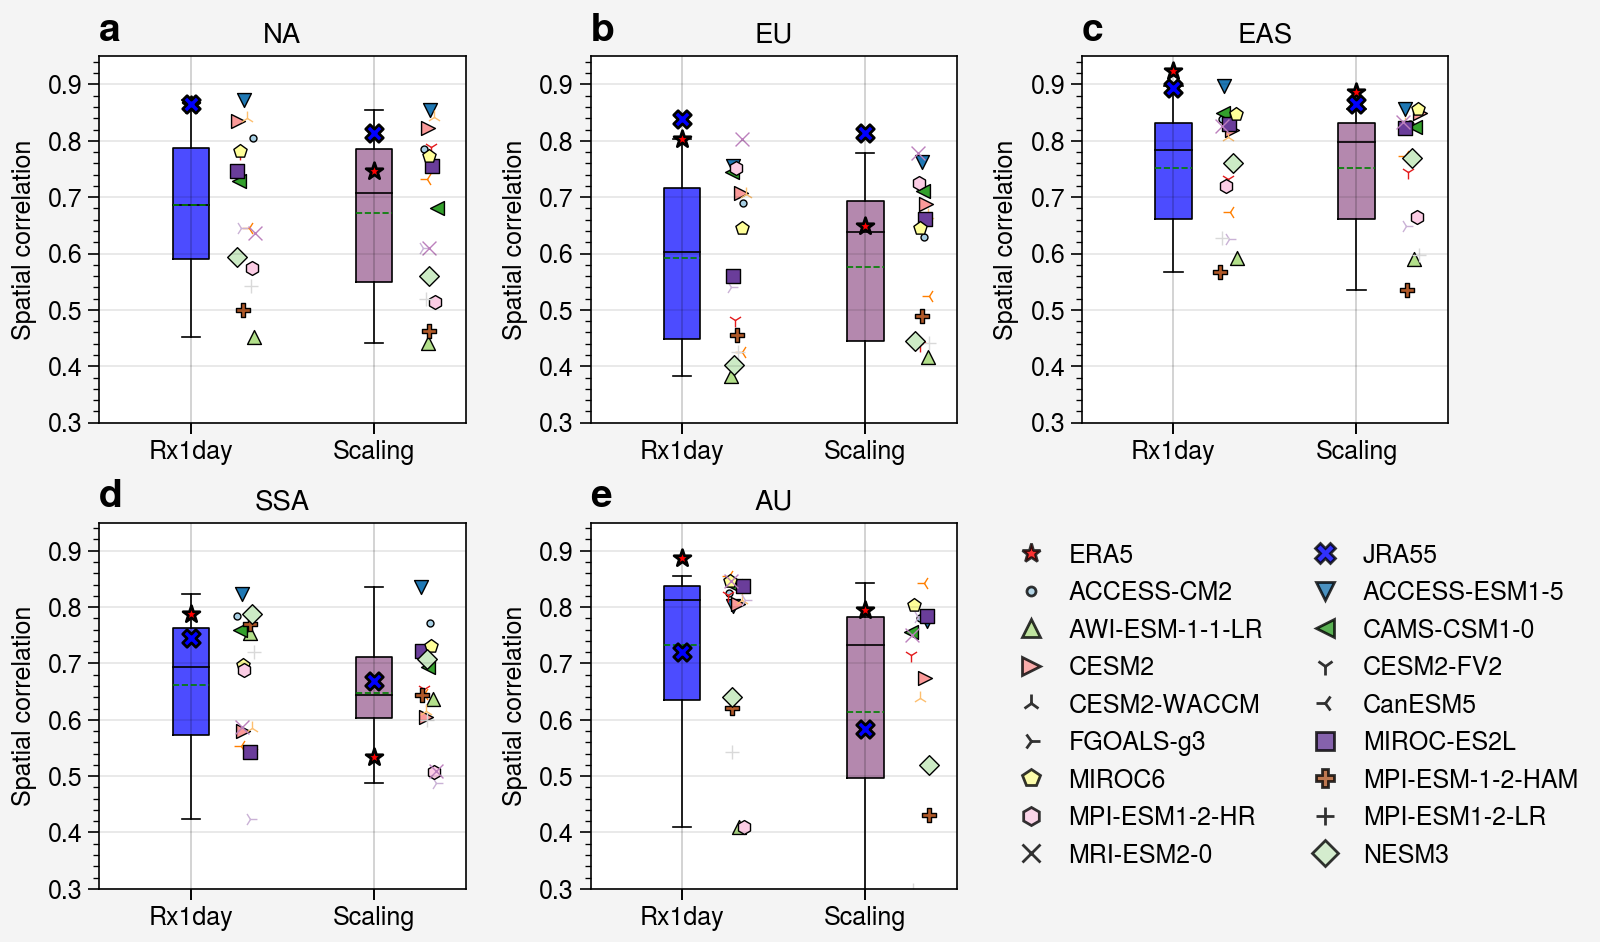

In [28]:
array = [[1,2,3],[4,5,0]]
fig, axs = pplot.subplots(array,wspace=(5),hspace=(4),width = 8,share=False)

masks = [mask_NA,mask_EU,mask_EAS,mask_SSA,mask_AU]
mask_name = ['NA','EU','EAS','SSA','AU']

for i in range(5):
    ax = axs[i]

    ensemble_names = [i.split('_')[0] + '_' + i.split('_')[2] for i in ensemble]
    prec_hist_spatial_cor_mask, scaling_hist_spatial_cor_mask = spatial_cor_for_mask_model(masks[i])
    prec_scaling_hist_spatial_cor_mask = pd.DataFrame({'Rx1day':prec_hist_spatial_cor_mask,'Scaling':scaling_hist_spatial_cor_mask},index=ensemble_names)
    prec_scaling_hist_spatial_cor_model = prec_scaling_hist_spatial_cor_mask.copy()
    prec_scaling_hist_spatial_cor_model['model'] = [i.split('_')[0] for i in ensemble]
    prec_scaling_hist_spatial_cor_model = prec_scaling_hist_spatial_cor_model.groupby('model').mean()

    era5_prec_spatial_cor_mask,era5_scaling_spatial_cor_mask,jra55_prec_spatial_cor_mask,jra55_scaling_spatial_cor_mask = spatial_cor_for_mask_reanalyses(masks[i])
    ax.box(prec_scaling_hist_spatial_cor_model, means=True,marker='.',meancolor='green',cycle=['blue','purple'],alpha=0.7,widths = 0.2)
    ax.scatter(x=0,y=era5_prec_spatial_cor_mask,markers='*',edgecolors='black',s=40,facecolors='red',linewidth=1,zorder=10)
    ax.scatter(x=1,y=era5_scaling_spatial_cor_mask,markers='*',edgecolors='black',s=40,facecolors='red',linewidth=1,zorder=10)
    ax.scatter(x=0,y=jra55_prec_spatial_cor_mask,markers='X',edgecolors='black',s=40,facecolors='blue',linewidth=1,zorder=10)
    ax.scatter(x=1,y=jra55_scaling_spatial_cor_mask,markers='X',edgecolors='black',s=40,facecolors='blue',linewidth=1,zorder=10)

    ax.set_ylim([0.3,0.95])
    ax.set_title(mask_name[i])
    ax.set_ylabel('Spatial correlation')
    add_panel_label(ax, ['a','b','c','d','e'][i], x=0, y = 1.12)
    
    for i in range(len(prec_scaling_hist_spatial_cor_model.index)):
        m = prec_scaling_hist_spatial_cor_model.index[i]
        ax.scatter(x = 0.3 + random.uniform(-0.05,0.05), y = prec_scaling_hist_spatial_cor_model.loc[m][0], marker = marker_model[i], edgecolors='black',s=25,facecolors=marker_color[i],linewidth=0.5)
        ax.scatter(x = 1.3 + random.uniform(-0.05,0.05), y = prec_scaling_hist_spatial_cor_model.loc[m][1], marker = marker_model[i], edgecolors='black',s=25,facecolors=marker_color[i],linewidth=0.5)

legend_elements = [Line2D([], [], marker='*' ,color='none',markerfacecolor='red', label='ERA5',alpha=0.8,markersize=7),
    Line2D([], [], marker='X' ,color='none',markerfacecolor='blue', label='JRA55',alpha=0.8,markersize=7)]
for i in range(len(prec_scaling_hist_spatial_cor_model.index)):
    legend_elements.append(
        Line2D([], [], marker=marker_model[i],color='none',markerfacecolor=marker_color[i], 
        label=prec_scaling_hist_spatial_cor_model.index[i],alpha=0.8,markersize=6.5))
handles = legend_elements
ax.legend(handles,['ERA5'].append(prec_scaling_hist_spatial_cor_model.index),frameon=False,ncol=2,bbox_to_anchor=(1.1,0.5),loc='center left',bbox_transform=ax.transAxes)

dir = '/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/Figures/'
plt.savefig(dir+'FigureS2_compare_with_HadEx3_subregions.pdf',dpi = 100)